# Homework 8

**Author**: Chase Coleman

**NYU ID**: N10879183

**Date**: 6 April 2016

Place all of the following in a single Jupyter notebook with the usual naming convention `firstname_lastname.ipynb`. Remember that you can use $\LaTeX$ expressions in the notebook. When you've finished your notebook, remember to restart the kernel (see the "Kernel" menu) and run again, just to check that everything runs with a fresh start. Also, go to the "File" menu and try to download your notebook as a PDF. If it doesn't work, some part of your notebook is broken (Probably a $\LaTeX$ expression). This makes it harder for me to print out and assess your work. Please fix it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import quantecon as qe
import scipy.stats as st
import seaborn as sb

from matplotlib import cm

np.set_printoptions(suppress=True, precision=4)
%matplotlib inline

## Exercise 1

### Question

Let $S$ be a discrete set. Show that if $\mathcal{P}(S)$ is compact as a subset of $(l_1(S), ||\cdot||)$, then $S$ must be finite.

### Answer

By contradiction.

$x_n = \{\frac{1}{n}, \dots, \frac{1}{n}, 0, \dots, 0, \dots \}$

all subsequences converge to $\{0, 0, 0, \dots, 0\}$, but that is no an element of $\mathcal{P}(S)$...

## Exercise 2

### Question

Consider the deterministic Markov chain $X_{t+1} = X_{t} + 1$ on $\mathbb{Z}$. The corresponding stochastic kernel is $p(x, y) = \mathbb{1}\{x = y-1\}$. Show that no stationary distribution exists.

### Answer

Implication of $\phi^*(x) = p \phi^*(x)$

## Precursor to Questions 3-6

The next exercise relates to $(s, S)$ inventory dynamics. I'll use the symbols $(q, Q)$ because the symbol $S$ is already taken. Throughout, $q$ and $Q$ are integers with $0 \leq q \leq Q$.

Consider a single firm with time $t$ inventory $X_t$. At the start of time $t$, if $X_t \leq q$ then the firm orders $Q - X_t$. Otherwise it orders nothing. At the end of $t$, demand $D_{t+1}$ is observed, and the firm meets this demand up to (but not exceeding) its current stock level. Any remaining inventory is carried over to the next period. This gives the next period inventory $X_{t+1}$.

Demand $\{D_t\}$ is assumed to be IID with
$$\mathbb{P}\{D_t = d\} = (1/2)^{d+1} \quad \forall d=0, 1, \dots$$
The associated stochastic kernel $p$ is defined (at least implicitly) by the expression
$$p(x, y) = \mathbb{P} \{X_{t+1} = y | X_t = x\}$$

In [2]:
def fill_transition_row(nstates, inv, f):
    """
    Given a current value of inventory determine the
    probability of transition to each other level of
    inventory (have 0 probability of transition up)
    
    Parameters
    ----------
    nstates : scalar(int)
        Number of possible states
    inv : scalar(int)
        The level of current inventory (after having
        restocked)
    f : scipy.stats.rv_discrete
        The distribution which describes the i.i.d.
        demand realizations
        
    Returns
    -------
    row : ArrayLike(float, ndim=1)
        A single row of a transition matrix which
        describes probability of moving from inv to
        each of possible nstates
    """
    # Allocate space
    row = np.empty(nstates)
    
    # Probability of going to zero inventory is
    # P(d>=inv) = 1 - P(d < inv) = 1 - cdf(inv-1)
    row[0] = 1 - f.cdf(inv-1)
    
    # Other rows can be filled with pmf or 0
    for xtp1 in range(1, nstates):
        if xtp1 <= inv:
            row[xtp1] = f.pmf(inv-xtp1)
        else:
            row[xtp1] = 0.0
        
    return row


In [3]:
def create_transition_matrix(q, Q, f):
    """
    Creates the transition matrix for the (q, Q) problem described
    above.
    
    If (X_{t} <= q) then the distribution over X_{t+1} is given
    by X_{t+1} = max(0, Q - D_{t+1}) with the probability of
    all non-zero X_{t+1} given by P(X_{t+1}=x) = P(Q-D_{t+1}=x)
    and P(X_{t+1} = 0) given by P(D_{t+1} >= Q).
    
    If (X_{t} > q) then the distribution over X_{t+1} is given by
    X_{t+1} = max(0, X_t - D_{t+1}) with the probability of all
    non-zero X_{t+1} given by P(X_{t+1}=x) = P(X_t - D_{t+1}=x)
    and P(X_{t+1}=0) given by P(D_{t+1} >= X_t
    
    Parameters
    ----------
    q : scalar(int)
        The level at which I restock my inventory
    Q : scalar(int)
        The amount of inventory I restock to
    f : scipy.stats.rv_discrete
        The distribution which describes the realizations of
        D_{t+1}.
        
    Returns
    -------
    Px : ArrayLike(float, ndim=2)
        The transition matrix which describes the moves
        between integer states from [0, 1, ..., Q]
    """
    # Make sure q and Q are integers
    q, Q = map(int, [q, Q])
    
    # Number of possible states is Q+1 and allocate space
    nstates = Q+1
    Px = np.empty((nstates, nstates))
    
    # Fill the transition matrix
    for xt in range(Q+1):
        # Check whether we fill inventory or not
        if xt <= q:
            inv = Q
        else:
            inv = xt
        
        # Fill one row at a time using a different function
        Px[xt, :] = fill_transition_row(nstates, inv, f)
    
    return Px


## Exercise 3

### Question

Argue that this stochastic kernel is globally stable for every $q$ and $Q$. (It's fine if you can come up with a reasonable probabilistic argument that doesn't necessarily involve a lot of calculations).

### Answer

Fill in more later. If $P_x$ is the transition matrix for $x$ then notice that $P_x^2$ has all positive elements and thus $P_x$ is aperiodic and irreducible --> globally stable

## Exercise 4

### Question

Let $\phi^*$ be the stationary distribution corresponding to given $(q, Q)$. Using `quantecon`'s `MarkovChain` class, compute the stationary distribution when $q = 2$ and $Q = 5$. You should get
$$ \phi^*_{2, 5} = (0.0625, 0.0625, 0.125, 0.25, 0.25, 0.25)$$
(By now hopefully you know that you should write a function that does most of the work)

### Answer

We create our transition matrix using the functions we have previously defined and then pass it to the `QuantEcon.MarkovChain` class. This class computes the stationary distribution for us.

In [4]:
def stationary_distribution_QE(q, Q, f):
    """
    Given the parameters for the (q, Q) model this function computes
    the stationary distribution across the states [0, ..., Q]
    
    Parameters
    ----------
    q : scalar(int)
        The level at which I restock my inventory
    Q : scalar(int)
        The amount of inventory I restock to
    f : scipy.stats.rv_discrete
        The distribution which describes the realizations of
        D_{t+1}.
        
    Returns
    -------
    psi : ArrayLike(float, ndim=1)
        The stationary distribution over states [0, ..., Q]
    """
    # Create the transition matrix
    Px = create_transition_matrix(q, Q, f)
    
    # Use QuantEcon to compute the stationary distribution
    mc_Px = qe.MarkovChain(Px)
    psi = mc_Px.stationary_distributions[0, :]
    
    return psi

In [5]:
q, Q = 2, 5
f = st.geom(0.5, loc=-1)

Px = create_transition_matrix(q, Q, f)
psi_qe = stationary_distribution_QE(q, Q, f)

In [6]:
print("The transition matrix created by our function is")
print(Px)

The transition matrix created by our function is
[[ 0.0312  0.0312  0.0625  0.125   0.25    0.5   ]
 [ 0.0312  0.0312  0.0625  0.125   0.25    0.5   ]
 [ 0.0312  0.0312  0.0625  0.125   0.25    0.5   ]
 [ 0.125   0.125   0.25    0.5     0.      0.    ]
 [ 0.0625  0.0625  0.125   0.25    0.5     0.    ]
 [ 0.0312  0.0312  0.0625  0.125   0.25    0.5   ]]


In [7]:
print("The stationary distribution calculated by QuantEcon is")
print(psi_qe)

The stationary distribution calculated by QuantEcon is
[ 0.0625  0.0625  0.125   0.25    0.25    0.25  ]


Notice that the reported stationary distribution is as expected.

## Exercise 5

### Question

Now compute the stationary distribution iteratively, using the ideas from the lecture. Terminate when successive iterates are closer together than some tolerance in the sense of $l_1$ distance. Compare your result with the result from the previous exercise.

### Answer

A mapping $T: M \rightarrow M$ on a metric space $(M, \rho)$ is called globally stable if

1. $T$ has a unique fixed point $x^* \in M$
2. $T^i x \rightarrow x^*$ as $i \rightarrow \infty$ for any $x \in M$.

In this case our metric space is given by $(\mathcal{P}(S), ||\cdot||_1)$. The mapping is provided by our Markov matrix $P_x$ and it is easy to show that $P_x$ maps from $\mathcal{P}(S)$ to $\mathcal{P}(S)$. We previously argued that $P_x$ was globablly stable, so we should be able to find our stationary distribution by computing $x P_x^i$ as $i \rightarrow \infty$ for any $x \in \mathcal{P}(S)$.

In [8]:
def stationary_distribution_iterative(q, Q, f, tol=1e-8, maxit=500):
    """
    Given the parameters for the (q, Q) model this function computes
    the stationary distribution across the states [0, ..., Q]
    
    Parameters
    ----------
    q : scalar(int)
        The level at which I restock my inventory
    Q : scalar(int)
        The amount of inventory I restock to
    f : scipy.stats.rv_discrete
        The distribution which describes the realizations of
        D_{t+1}.
    tol : scalar(float)
        Tolerance level under l1 norm
    maxit : scalar(int)
        Maximum number of iterations
        
    Returns
    -------
    psi : ArrayLike(float, ndim=1)
        The stationary distribution over states [0, ..., Q]
    """
    # Iteration parameters
    dist, it = 10, 0
    
    # Create transition matrix and initial dist
    Px = create_transition_matrix(q, Q, f)
    x0 = np.ones(Q+1) / (Q+1)
    
    # Iterate
    while (dist > tol) and (it < maxit):
        # One step
        xupd = x0 @ Px
        
        # Update distance and distribution
        dist = np.sum(np.abs(xupd - x0))
        x0[:] = xupd[:]
        
    return x0


In [9]:
q, Q = 2, 5
f = st.geom(0.5, loc=-1)

psi_it = stationary_distribution_iterative(q, Q, f)

print("The stationary distribution computed iteratively is")
print(psi_it)

The stationary distribution computed iteratively is
[ 0.0625  0.0625  0.125   0.25    0.25    0.25  ]


Notice that we arrived at the same conclusion iteratively as we did using the `QuantEcon.MarkovChain` routines.

## Exercise 6

### Question

Finally, set $Q = 20$ and plot the stationary distribution for $q = 2, 5, 10, 15$. Give some interpretation for what you see.

### Answer

In [10]:
def compute_stationary_distributions_qs(qs, Q, f):
    """
    Given the parameters for the (q, Q) model this function computes
    the stationary distribution across the states [0, ..., Q]
    
    Parameters
    ----------
    qs : ArrayLike(int, ndim=1)
        An array of levels at which I restock my inventory -- We
        will compute the stationary distribution for each one
    Q : scalar(int)
        The amount of inventory I restock to
    f : scipy.stats.rv_discrete
        The distribution which describes the realizations of
        D_{t+1}.
        
    Returns
    -------
    psi : ArrayLike(float, ndim=1)
        The stationary distribution over states [0, ..., Q]
    """
    # Allocate space for stationary distributions
    nqs = qs.size
    nstates = Q+1
    psi_qs = np.empty((nqs, nstates))
    
    # Iterate over q values
    for (iq, q) in enumerate(qs):
        psi = stationary_distribution_QE(q, Q, f)
        psi_qs[iq, :] = psi
    
    return psi_qs

In [11]:
qs = np.array([0, 2, 5, 10, 15], dtype=int)
Q = 20
f = st.geom(0.5, loc=-1)

psis = compute_stationary_distributions_qs(qs, Q, f)

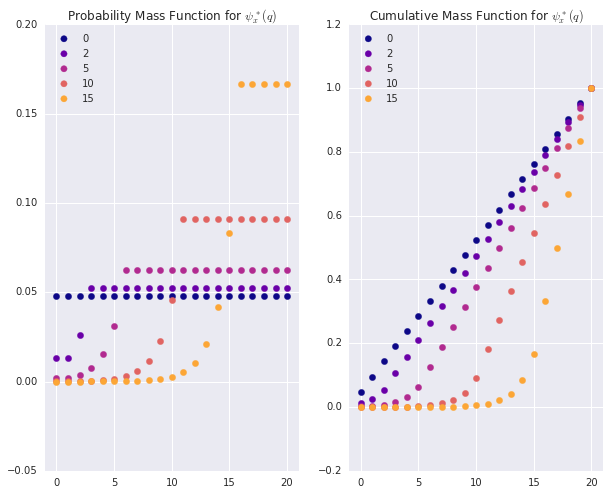

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
c = [cm.plasma(i) for i in np.linspace(0, 0.8, qs.size)]

states = np.arange(Q+1)
for (iq, q) in enumerate(qs):
    # Probability Mass Function
    ax[0].set_title(r"Probability Mass Function for $\psi^*_x(q)$")
    ax[0].scatter(states, psis[iq, :], label=q, color=c[iq], s=40)
    ax[0].set_xlim(-1, 21)
    
    # Cumulative Mass Function
    ax[1].set_title(r"Cumulative Mass Function for $\psi^*_x(q)$")
    ax[1].scatter(states, np.cumsum(psis[iq, :]), label=q, color=c[iq],
                  s=40)
    ax[1].set_xlim(-1, 21)

ax[0].legend(loc=2)
ax[1].legend(loc=2)

We can notice several points from the above two graphs:

* When we have a higher value of $q$, we are more likely to reset. This leads us to spend more time at very extreme values which we can see from the fact that as $q$ increases, the probability of being at values near $Q$ increases. In particular, for $q_1 > q_2$ we see that $p_1(q_1) > p_2(q_1)$.
* When we have low values of $q$ we reset much less frequently. This leads to the probability distribution being closer to uniform. In fact, if $q$ is equal to 0 then the stationary distribution is uniform (can I show this?).

## Tests for code above

While I was writing the code for this lecture I wrote a few short tests to make sure the code was doing what I expected it to.

In [13]:
# Short test to check whether all transition matrices have
# rows that sum to 1
q, Q = 5, 10
f = st.geom(0.5, loc=-1)

print("Beginning tests of `fill_transition_row`")
for i in range(Q+1):
    r = fill_transition_row(Q+1, i, f)
    assert(abs(r.sum() - 1) < 1e-14)
print("Passed tests of `fill_transition_row`\n\n")

print("Beginning tests of `create_transition_matrix`")
assert(np.all(create_transition_matrix(10, 10, f) > 0))
print("Passed tests of `create_transition_matrix`\n\n")

Beginning tests of `fill_transition_row`
Passed tests of `fill_transition_row`


Beginning tests of `create_transition_matrix`
Passed tests of `create_transition_matrix`


